In [1]:
using CSV, DataFrames, Gadfly, Distributions, SparseArrays, LinearAlgebra

include("iGMRF.jl");
include("dataGen.jl");

# Création de la grille à 9 cellules

Chaque cellule est représentée par un triplet $[\mu, \sigma, \xi]$ indiquant les vraie valeur des paramètres de la GEV à déterminer.

In [2]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂
# Hyperparamètres
κᵤ = 100.0;
# Matrice de structure
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;

In [3]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 10.0212  10.0154  9.88228
 10.0775  10.0098  9.94918
 10.0956   9.9755  9.97355

In [4]:
grid_target[:, :, 2]

3×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [5]:
grid_target[:, :, 3]

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

# Génération de données

Le but est de générer des données sur chaque cellule à partir des paramètres de la GEV de la grille cible.

In [6]:
nobs = 100;
data = generateData(grid_target, nobs);

In [7]:
data

9-element Vector{Vector{Float64}}:
 [12.240682784141626, 9.621417291612469, 9.754494171763968, 12.271969563649202, 9.010088679836304, 10.37854664173395, 9.953170110473183, 9.445009003021907, 9.742009013625772, 9.570691209584776  …  10.518164573659204, 9.930013357326203, 10.282186137930879, 12.850825190676971, 11.539774471964721, 9.408520146607469, 10.911372616309231, 8.729801983142732, 8.72967686719628, 11.836572621374048]
 [11.273789202970812, 8.631556095806973, 13.163945842014405, 11.344148819126897, 9.546754812779685, 10.288636123061432, 8.323184365488917, 11.519918761572495, 10.633947875839283, 9.701374233994922  …  11.842867771041316, 10.125426468920546, 10.559271503126375, 11.915013128851271, 11.83414170304287, 10.090763718674232, 9.618733796527398, 11.037493453323496, 12.569207209872223, 10.34323657298342]
 [10.84714848560555, 10.09386643901673, 11.374159042999196, 10.054626371286963, 11.072357692987763, 9.28577559547066, 11.744733738776487, 9.621447951938798, 9.092795759344487,

# Modèle 

In [69]:
include("malaWG.jl");

niter = 10;
h = 1;
θ₀ = vcat([10], fill(10, m))
F = iGMRF(m₁, m₂, 0)
nchains = 1;

κᵤ, μ = malaWG(niter, h, θ₀, Y=data, F=F, nchains=nchains);

warming_size = Int(0.2 * niter)

newμ = μ[warming_size:end, :, :];

κ̂ᵤ = mean(κᵤ[warming_size:end, 1]);
μ̂ = mean(newμ.value[:, :, 1], dims=1);

In [70]:
changerate(newμ).value

10×1×1 Array{Float64, 3}:
[:, :, 1] =
 0.907
 0.907
 0.907
 0.907
 0.907
 0.907
 0.907
 0.907
 0.907
 0.907

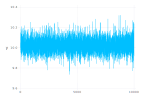

In [61]:
plot(y=μ.value[:, 1, 1], Geom.line)

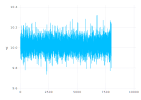

In [62]:
plot(y=newμ.value[:, 1, 1], Geom.line)

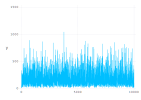

In [63]:
plot(y=κᵤ, Geom.line)

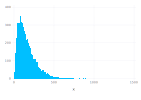

In [64]:
plot(x=κᵤ, Geom.histogram)

In [26]:
κ̂ᵤ

167.46785329287027

In [19]:
summarystats(newμ)

      Mean        SD       Naive SE       MCSE         ESS   
μ1 10.024288 0.065821346 0.0023256829 0.0102694093  41.081150
μ2 10.011436 0.056216420 0.0019863095 0.0096892899  33.662198
μ3  9.982375 0.054763367 0.0019349684 0.0067885322  65.077149
μ4 10.035598 0.052946334 0.0018707667 0.0092526551  32.744552
μ5 10.000692 0.046309580 0.0016362686 0.0071268583  42.222645
μ6  9.992273 0.050012131 0.0017670918 0.0068583947  53.174788
μ7  9.989096 0.058319257 0.0020606096 0.0071364130  66.782706
μ8  9.969106 0.053991691 0.0019077026 0.0050448214 114.541339
μ9  9.980594 0.055234232 0.0019516056 0.0044773594 152.185308



In [355]:
reshape(μ̂, m₁, m₂)'

10×10 adjoint(::Matrix{Float64}) with eltype Float64:
 10.0407   10.0421   10.0251   10.0006   …   9.97657  10.0221   10.0177
 10.0025   10.0233   10.0168    9.99198      9.99947  10.0085   10.0276
 10.0109    9.99722   9.99937   9.99572     10.005    10.0044   10.0058
  9.99101   9.94329   9.97613   9.99903     10.0123   10.0113    9.99111
  9.96091   9.94771   9.98118  10.0066      10.0209   10.0053    9.94571
  9.97583   9.97834   9.99041   9.98719  …  10.0068    9.98971   9.95576
  9.97807   9.99219   9.9909    9.97         9.96756   9.99006   9.97319
  9.96765   9.97086   9.97006   9.9676       9.95945   9.94796   9.98551
  9.98134  10.0008    9.97981   9.96263      9.94495   9.9349    9.96293
 10.015    10.0127   10.0038    9.98651      9.93998   9.95234   9.9297

In [356]:
grid_target[:, :, 1]

10×10 Matrix{Float64}:
 10.0883   10.1215   10.0313   10.1106   …  10.0192   10.013     9.9882
 10.093    10.0994   10.0888   10.026        9.95252   9.99376  10.0553
 10.0916   10.0074    9.89158   9.94742     10.0047   10.0734   10.087
 10.0949    9.90395   9.93676   9.95348     10.1303   10.0289   10.0361
  9.99375   9.9848    9.96131  10.0436      10.0975   10.0828    9.94785
  9.9527    9.93849  10.0105   10.0239   …  10.0303   10.1027    9.97924
  9.96223   9.89523   9.99495   9.93144     10.0485    9.98309   9.92488
  9.89245   9.93145   9.83326   9.94377      9.91406   9.99474   9.97969
  9.99391  10.0087    9.88059   9.86625      9.95615   9.848     9.88811
 10.0186   10.0311    9.97917   9.9312       9.88692   9.78898   9.79064

Distance entre les deux matrices

In [357]:
norm(reshape(μ̂, m₁, m₂)' .- grid_target[:, :, 1], 2) / m

0.006454207010314841

In [141]:
describe(newμ)

Iterations = 5000:10000
Thinning interval = 1
Chains = 1
Samples per chain = 5001

Empirical Posterior Estimates:
      Mean         SD           Naive SE           MCSE        ESS   
μ1  9.9938486 0.031678116 4.479514250055×10⁻⁴ 0.00079972181 1569.0646
μ2  9.9555134 0.030485811 4.310913605393×10⁻⁴ 0.00090384754 1137.6407
μ3  9.6022453 0.031125180 4.401325037265×10⁻⁴ 0.00084183185 1367.0142
μ4 10.1947410 0.029944566 4.234377697789×10⁻⁴ 0.00077038113 1510.8619
μ5 10.0186668 0.029986766 4.240345048221×10⁻⁴ 0.00079550499 1420.9325
μ6  9.8499529 0.029781283 4.211288329974×10⁻⁴ 0.00072285069 1697.4211
μ7 10.2727510 0.030851025 4.362557518762×10⁻⁴ 0.00079018313 1524.3464
μ8 10.0001883 0.030205039 4.271210549105×10⁻⁴ 0.00079481343 1444.2036
μ9  9.9885437 0.029885875 4.226078405004×10⁻⁴ 0.00077906303 1471.5898

Quantiles:
      2.5%     25.0%     50.0%     75.0%     97.5%  
μ1  9.930650  9.972615  9.994071 10.015472 10.053591
μ2  9.897514  9.933886  9.955435  9.975946 10.015136
μ3  9.540824  9

In [118]:
using Mamba

sim = Chains(
    copy(θ'), 
    names=[
        "κᵤ", 
        "μ1",
        "μ2", 
        "μ3", 
        "μ4", 
        "μ5", 
        "μ6", 
        "μ7", 
        "μ8", 
        "μ9",
        "μ10",
        "μ11", 
        "μ12", 
        "μ13", 
        "μ14", 
        "μ15", 
        "μ16", 
        "μ17", 
        "μ18",
        "μ19",
        "μ20", 
        "μ21", 
        "μ22", 
        "μ23", 
        "μ24", 
        "μ25", 
        "μ26", 
        "μ27",
        "μ28",
        "μ29", 
        "μ30", 
        "μ31", 
        "μ32", 
        "μ33", 
        "μ34", 
        "μ35", 
        "μ36"
    ]
);

summarystats(sim)

DimensionMismatch: DimensionMismatch: size(value, 2) and names length differ